In [1]:
import time
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import numba as nb
import ROOT
import awkward as ak
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
import math
import numpy as np

Welcome to JupyROOT 6.24/06


In [17]:
dir_ntuples = '/afs/cern.ch/work/n/nchernya/CERN/L1Upgrade/CMSSW_11_1_7/src/FastPUPPI/NtupleProducer/python/ntuples_1p0/'
#events = uproot.open("{}/perfNano_DYToLL_PU200.110X_v2.lep.root:Events".format(dir_ntuples))
events = uproot.open("{}/perfNano_GluGluToHHTo4B_PU200.110X_v2.lep.root:Events".format(dir_ntuples))
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | uint32_t                 | AsDtype('>u4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nPFMu                | uint32_t                 | AsDtype('>u4')
PFMu_eta             | float[]                  | AsJagged(AsDtype('>f4'))
PFMu_phi             | float[]                  | AsJagged(AsDtype('>f4'))
PFMu_pt              | float[]                  | AsJagged(AsDtype('>f4'))
PFMu_vz              | float[]                  | AsJagged(AsDtype('>f4'))
PFMu_charge          | int32_t[]                | AsJagged(AsDtype('>i4'))
PFMu_quality         | int32_t[]                | AsJagged(AsDtype('>i4'))
nTkEleEB             | uint32_t                 | AsDtype('>u4')
TkEleEB_caloEta      | float[]                  | AsJagged(AsDt

In [18]:
sta_muons = events.arrays(
    ["pt", "eta", "phi", "charge","quality"],
    aliases={"pt": "StaMu_pt", "eta": "StaMu_eta", "phi": "StaMu_phi", "charge": "StaMu_charge","quality":"StaMu_quality"}
)
pf_muons = events.arrays(
    ["pt", "eta", "phi", "charge","quality"],
    aliases={"pt": "PFMu_pt", "eta": "PFMu_eta", "phi": "PFMu_phi", "charge": "PFMu_charge","quality":"PFMu_quality"}
)
gen_muons = events.arrays(
    ["pt", "eta", "phi", "charge","prompt"],
    aliases={"pt": "GenMu_pt", "eta": "GenMu_eta", "phi": "GenMu_phi", "charge": "GenMu_charge","prompt":"GenMu_prompt"}
)


In [19]:
def deltaPhi( p1, p2):
    '''Computes delta phi, handling periodic limit conditions.'''
    res = p1 - p2
    while res > math.pi:
        res -= 2*math.pi
    while res < -math.pi:
        res += 2*math.pi
    return res

def deltaR( *args ):
    return math.sqrt( deltaR2(*args) )

def deltaR2( e1, p1, e2, p2):
    de = e1 - e2
    dp =  deltaPhi(p1, p2)
    return de*de + dp*dp

def deltaR2_array( e1, p1, e2, p2):
    de = e1 - e2
    dp =  np.array([deltaPhi(p1_phi, p2_phi) for p1_phi,p2_phi in zip(p1,p2)])
    return de*de + dp*dp

In [20]:
events_record = ak.zip({"pf_muons":pf_muons, "sta_muons":sta_muons,"gen_muons":gen_muons,"event":events.arrays("event")})


In [21]:
gen_dr = 0.2
dr2cut = gen_dr*gen_dr

all_reco_matched_pf_muons = []
all_reco_matched_sta_muons = []
gen_pf_muons = []
empty_record = ak.from_iter({"pt": -4, "eta": -4, "phi": -4, "charge": -4, "prompt": -4})
non_matched_pf_events = []
non_matched_sta_events = []

for i_e,e in enumerate(events_record):
    valid_pf = []
    valid_gen = []
    matched_pf = []
    matched_sta = []
    for i_gen in range(len(e.gen_muons.pt)):
        gen_mu = e.gen_muons[:,i_gen]
        if (gen_mu.pt < 0) or (abs(gen_mu.eta) > 2.4)or (abs(gen_mu.eta) < 0) : continue #or (gen_mu.prompt < 2): continue #without mu promt #or : continue 
        gen_pf_muons.append(ak.to_list(e.gen_muons[:,i_gen]))
        matched_pt = -1;
        matched_pt_sta = -1;

        for i_pf in range(len(e.pf_muons.pt)):
            pf_mu = e.pf_muons[:,i_pf]
            if (pf_mu.pt < 0) or (abs(pf_mu.eta) > 2.4)or (abs(pf_mu.eta) < 0): continue
            if (deltaR2(pf_mu.eta,pf_mu.phi,gen_mu.eta,gen_mu.phi) < dr2cut):
                if (pf_mu.pt > matched_pt):
                    if (matched_pt >= 0): 
                        matched_pf.pop()
                    matched_pf.append(i_pf)
                    matched_pt = pf_mu.pt
        if (matched_pt >= 0): 
            all_reco_matched_pf_muons.append(ak.to_list(e.pf_muons[:,matched_pf[0]]))
            matched_pf = []
        else : 
            all_reco_matched_pf_muons.append(ak.to_list(empty_record))
            #non_matched_pf_events.append(ak.to_list(e.event))
            non_matched_pf_events.append(i_e)
            

        for i_mu in range(len(e.sta_muons.pt)):
            mu = e.sta_muons[:,i_mu]
            if (mu.pt < 0) or (abs(mu.eta) > 2.4)or (abs(mu.eta) < 0): continue
            if (deltaR2(mu.eta,mu.phi,gen_mu.eta,gen_mu.phi) < dr2cut):
                if (mu.pt > matched_pt_sta):
                    if (matched_pt_sta >= 0): 
                        matched_sta.pop()
                    matched_sta.append(i_mu)
                    matched_pt_sta = mu.pt
        if (matched_pt_sta >= 0): 
            all_reco_matched_sta_muons.append(ak.to_list(e.sta_muons[:,matched_sta[0]]))
            matched_sta = []
        else : 
            all_reco_matched_sta_muons.append(ak.to_list(empty_record)) 
            #non_matched_sta_events.append(ak.to_list(e.event))
            non_matched_sta_events.append(i_e)


all_reco_matched_pf_muons = ak.Array(all_reco_matched_pf_muons)
gen_pf_muons = ak.Array(gen_pf_muons)
all_reco_matched_sta_muons = ak.Array(all_reco_matched_sta_muons)

#non_matched_pf_events = ak.to_numpy(ak.Array(non_matched_pf_events).event)
#non_matched_sta_events = ak.to_numpy(ak.Array(non_matched_sta_events).event)
non_matched_pf_only = list(set(non_matched_pf_events) - set(non_matched_sta_events)) #order is lost this way, but we just want to analyze events




In [166]:
print(len(non_matched_pf_events),len(non_matched_sta_events),len(non_matched_pf_only))


4161 4591 1112


In [167]:
def makeEffHist(name, refArr, corrArr, corrThr, xmax, logxbins=None):
    nbins=20
    not_matched = []
    if logxbins:
        nbins, nratio = int(logxbins[0]), float(logxbins[1])
        if nratio == 1:
            ret = ROOT.TEfficiency(name.replace(" ","_")+"_eff","",nbins,0,xmax)
        else:
            step = pow(nratio, 1.0/nbins)
            base = xmax*(step-1)/(nratio - 1)
            edges = [0]
            for i in xrange(nbins+1):
                edges.append(edges[-1] + base * pow(step, i))
            ret = ROOT.TEfficiency(name.replace(" ","_")+"_eff","",nbins,array('d',edges))
    else:
        ret = ROOT.TEfficiency(name+"_eff","",nbins,0,xmax)
        ret_nom = ROOT.TH1D(name+"_nom","",nbins,0,xmax)
        ret_denom = ROOT.TH1D(name+"_denom","",nbins,0,xmax)
    for i in range(0,len(refArr)):
        if corrArr[i]>corrThr :not_matched.append(i)
        ret.Fill(corrArr[i]>corrThr,refArr[i])
        ret_nom.Fill(corrArr[i],corrArr[i]>corrThr)
        ret_denom.Fill(refArr[i])
    ret_nom.Divide(ret_denom)
    ret.SetStatisticOption(ret.kFCP)
    return ret,not_matched,ret_nom

In [9]:
ret,not_matched,ret2 = makeEffHist('name',gen_pf_muons[:].pt,all_reco_matched_pf_muons[:].pt,30,70)

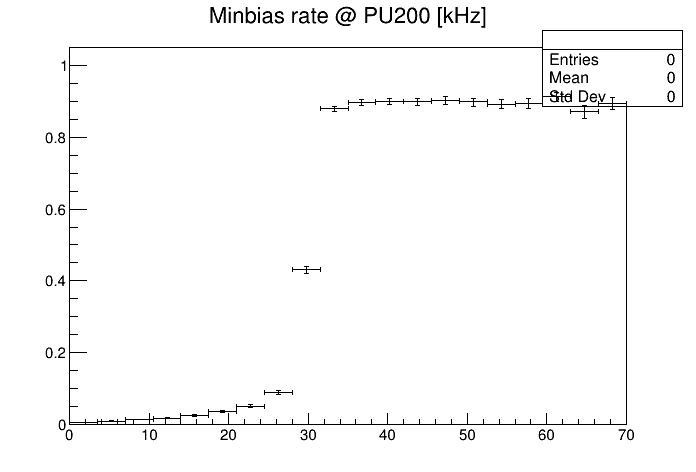

In [10]:
c1 = ROOT.TCanvas('c1', 'Dynamic Slice Example', 10, 10, 700, 500 )
frame = ROOT.TH1D("","Minbias rate @ PU200 [kHz]", 100, 0, 70)
frame.GetYaxis().SetRangeUser(0.0, 1.05)
frame.Draw()
#ret2.Draw()
ret.Draw("same")
c1.Draw()

In [11]:
print(np.sum(all_reco_matched_sta_muons.pt<0)/len(all_reco_matched_sta_muons))
print(np.sum(all_reco_matched_pf_muons.pt<0)/len(all_reco_matched_pf_muons))

0.5332426619433198
0.3719003036437247


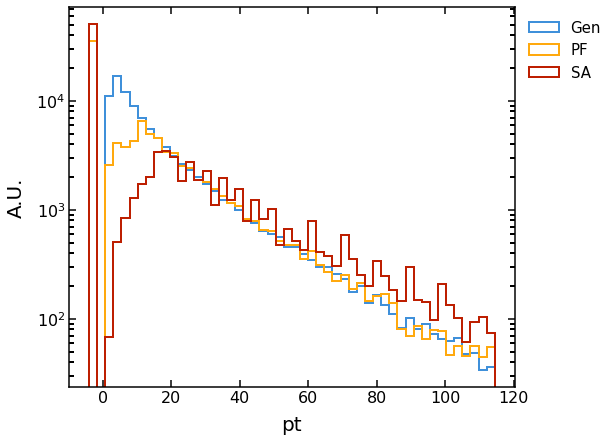

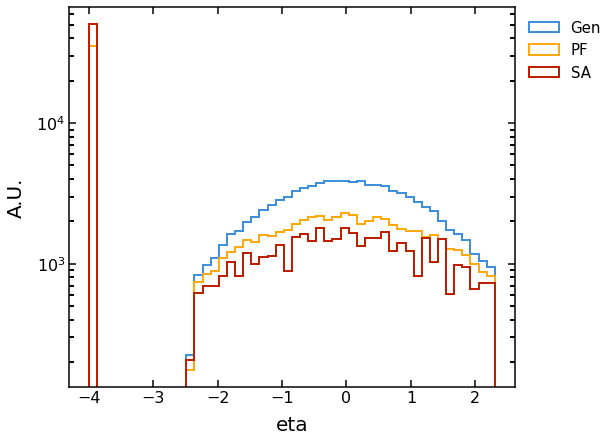

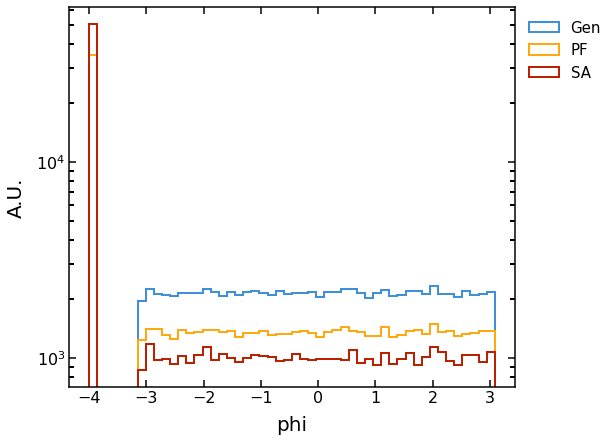

In [12]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

for what in "pt,eta,phi".split(','):
    xmax = np.quantile(all_reco_matched_pf_muons[:][what].tolist(),0.995)
    xmin = np.min(all_reco_matched_pf_muons[:][what].tolist())
    n_bins = 50
    plot_range = (xmin,xmax)
    _,bins,_ = plt.hist(gen_pf_muons[:][what], bins=n_bins,range = plot_range, histtype='step', fill=False, linewidth=2,label='Gen')
    _,_,_ = plt.hist(all_reco_matched_pf_muons[:][what], bins=bins, histtype='step', fill=False, linewidth=2,label='PF')
    _,_,_ = plt.hist(all_reco_matched_sta_muons[:][what], bins=bins, histtype='step', fill=False, linewidth=2,label='SA')
    plt.yscale('log')
    plt.xlabel(what)#(r'$p_{T}$')
    plt.ylabel("A.U.")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.show()



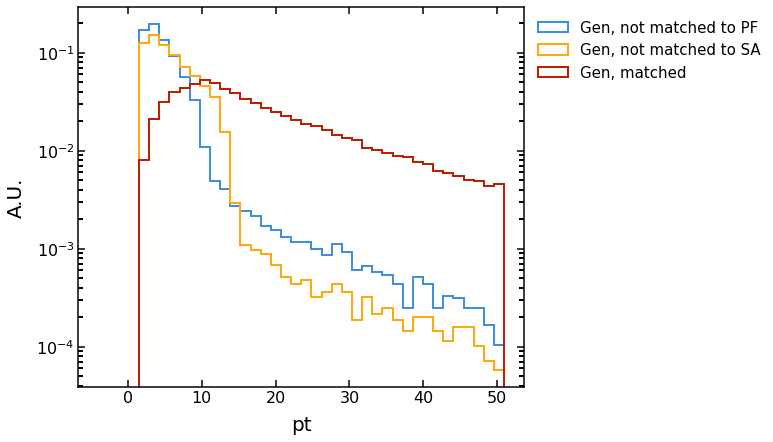

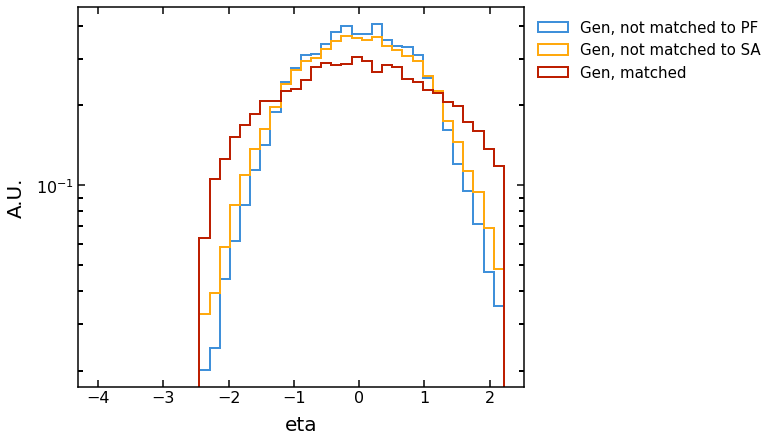

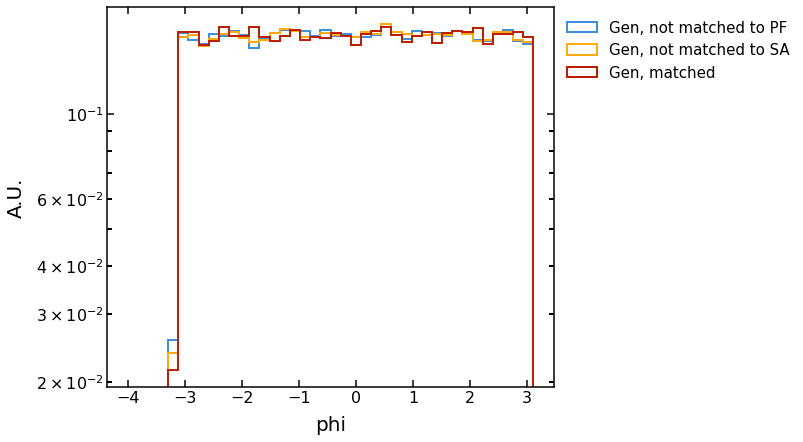

In [13]:
mask_non = np.where(all_reco_matched_pf_muons[:].pt<0)
mask_mat = np.where(all_reco_matched_pf_muons[:].pt>=0)
mask_non_sta = np.where(all_reco_matched_sta_muons[:].pt<0)

for what in "pt,eta,phi".split(','):
    xmax = np.quantile(gen_pf_muons[what][mask_non].tolist(),0.995)
    xmin =  np.min(all_reco_matched_pf_muons[what][mask_non].tolist())
    n_bins = 40
    plot_range = (xmin,xmax)
    _,bins,_ = plt.hist(gen_pf_muons[what][mask_non], bins=n_bins,range = plot_range,density=True, histtype='step', fill=False, linewidth=2,label='Gen, not matched to PF')
    _,bins,_ = plt.hist(gen_pf_muons[what][mask_non_sta], bins=n_bins,range = plot_range,density=True, histtype='step', fill=False, linewidth=2,label='Gen, not matched to SA')
  #  _,_,_ = plt.hist(all_reco_matched_sta_muons[what][mask_non], bins=bins, histtype='step',density=True, fill=False, linewidth=2,label='Sta, non matched')
    _,_,_ = plt.hist(gen_pf_muons[what][mask_mat], bins=bins, histtype='step',density=True, fill=False, linewidth=2,label='Gen, matched')
  #  _,_,_ = plt.hist(all_reco_matched_sta_muons[what][mask_mat], bins=bins, histtype='step',density=True, fill=False, linewidth=2,label='Sta, matched')
    plt.yscale('log')
    plt.xlabel(what)#(r'$p_{T}$')
    plt.ylabel("A.U.")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    #plt.legend(fontsize=15)
    plt.show()


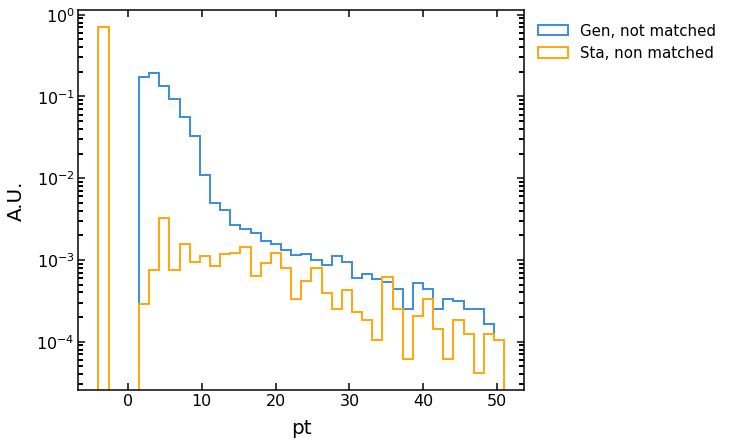

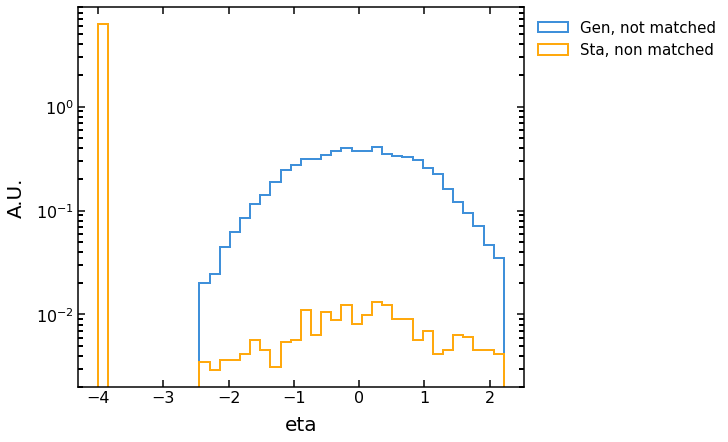

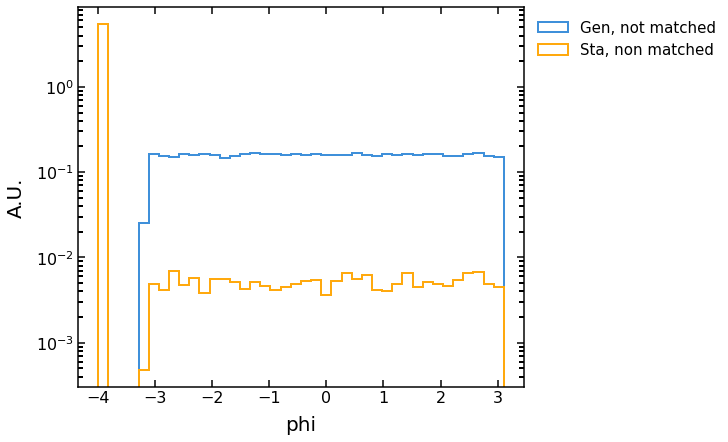

In [14]:
mask_non = np.where(all_reco_matched_pf_muons[:].pt<0)
mask_mat = np.where(all_reco_matched_pf_muons[:].pt>=0)

for what in "pt,eta,phi".split(','):
    xmax = np.quantile(gen_pf_muons[what][mask_non].tolist(),0.995)
    xmin =  np.min(all_reco_matched_pf_muons[what][mask_non].tolist())
    n_bins = 40
    plot_range = (xmin,xmax)
    _,bins,_ = plt.hist(gen_pf_muons[what][mask_non], bins=n_bins,range = plot_range,density=True, histtype='step', fill=False, linewidth=2,label='Gen, not matched')
    _,_,_ = plt.hist(all_reco_matched_sta_muons[what][mask_non], bins=bins, histtype='step',density=True, fill=False, linewidth=2,label='Sta, non matched')
  #  _,_,_ = plt.hist(gen_pf_muons[what][mask_mat], bins=bins, histtype='step',density=True, fill=False, linewidth=2,label='Gen, matched')
  #  _,_,_ = plt.hist(all_reco_matched_sta_muons[what][mask_mat], bins=bins, histtype='step',density=True, fill=False, linewidth=2,label='Sta, matched')
    plt.yscale('log')
    plt.xlabel(what)#(r'$p_{T}$')
    plt.ylabel("A.U.")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.show()


Fraction > 0.7 : 0.06321916881007175
Fraction > 0.75 : 0.05414918099363747


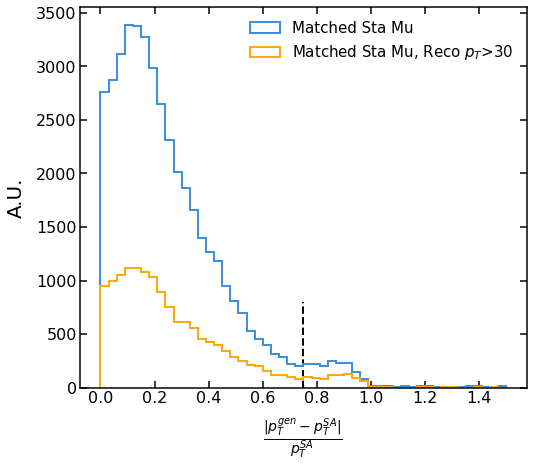

In [15]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


mask_mat = np.where(all_reco_matched_pf_muons[:].pt>=0,True,False)
mask_mat_30 = np.where(all_reco_matched_pf_muons[:].pt>=30,True,False)*np.where(gen_pf_muons[:].pt>0.,True,False)*(np.where(abs(gen_pf_muons[:].eta)>=0.,True,False))

xmax = 1.5
xmin =  0
n_bins = 50
plot_range = (xmin,xmax)
res = abs(gen_pf_muons.pt[mask_mat]-all_reco_matched_sta_muons.pt[mask_mat])/all_reco_matched_sta_muons.pt[mask_mat]
res_30 = abs(gen_pf_muons.pt[mask_mat_30]-all_reco_matched_sta_muons.pt[mask_mat_30])/all_reco_matched_sta_muons.pt[mask_mat_30]
print('Fraction > 0.7 :',len(res_30[res_30>0.7])/len(res_30))
print('Fraction > 0.75 :',len(res_30[res_30>0.75])/len(res_30))
_,bins,_ = plt.hist(res, bins=n_bins,range = plot_range,density=False, histtype='step', fill=False, linewidth=2,label='Matched Sta Mu')
_,_,_ = plt.hist(res_30, bins=bins,density=False, histtype='step', fill=False, linewidth=2,label=r'Matched Sta Mu, Reco $p_T$>30')#, Gen |eta|>2.')
plt.vlines(0.75, 0, 800,color='black',linestyle='--') 
plt.xlabel(r'$\frac{|p^{gen}_{T}-p^{SA}_{T}|}{p^{SA}_{T}}$')#(r'$p_{T}$')
plt.ylabel("A.U.")
#plt.yscale('log')
plt.legend(fontsize=15)
plt.show()


In [22]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


mask_mat = np.where(all_reco_matched_pf_muons[:].pt>=0,True,False)
mask_mat_18 = np.where(all_reco_matched_pf_muons[:].pt>=18,True,False)*np.where(gen_pf_muons[:].pt>0.,True,False)*(np.where(abs(gen_pf_muons[:].eta)>=0.,True,False))
mask_mat_30 = np.where(all_reco_matched_pf_muons[:].pt>=30,True,False)*np.where(gen_pf_muons[:].pt>0.,True,False)*(np.where(abs(gen_pf_muons[:].eta)>=0.,True,False))
mask_mat_10 = np.where(all_reco_matched_pf_muons[:].pt>=10,True,False)*np.where(gen_pf_muons[:].pt>0.,True,False)*(np.where(abs(gen_pf_muons[:].eta)>=0.,True,False))
mask_mat_12 = np.where(all_reco_matched_pf_muons[:].pt>=12,True,False)*np.where(gen_pf_muons[:].pt>0.,True,False)*(np.where(abs(gen_pf_muons[:].eta)>=0.,True,False))
res = -(gen_pf_muons.pt[mask_mat]-all_reco_matched_sta_muons.pt[mask_mat])/gen_pf_muons.pt[mask_mat]
res_30 = -(gen_pf_muons.pt[mask_mat_30]-all_reco_matched_sta_muons.pt[mask_mat_30])/gen_pf_muons.pt[mask_mat_30]
res_18 = -(gen_pf_muons.pt[mask_mat_18]-all_reco_matched_sta_muons.pt[mask_mat_18])/gen_pf_muons.pt[mask_mat_18]
res_10 = -(gen_pf_muons.pt[mask_mat_10]-all_reco_matched_sta_muons.pt[mask_mat_10])/gen_pf_muons.pt[mask_mat_10]
res_12 = -(gen_pf_muons.pt[mask_mat_12]-all_reco_matched_sta_muons.pt[mask_mat_12])/gen_pf_muons.pt[mask_mat_12]




Fraction > 1. : 0.003316637335860295
Fraction > 1. : 0.008813077469793887


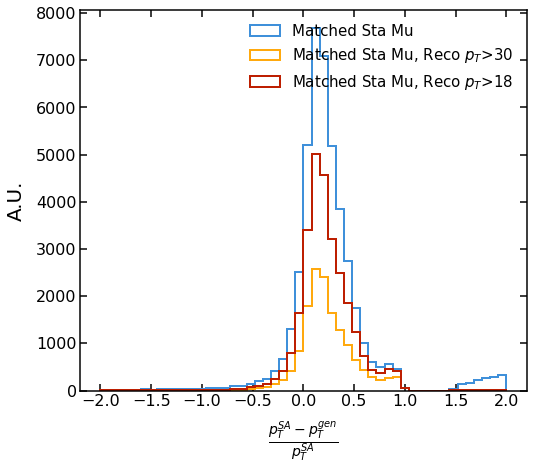

In [52]:
xmax = 2
xmin =  -2
n_bins = 50
plot_range = (xmin,xmax)
print('Fraction > 1. :',len(res_30[res_30>1.0])/len(res_30))
print('Fraction > 1. :',len(res_18[res_18>1.])/len(res_18)) #plot this as a function of gen pt
_,bins,_ = plt.hist(res, bins=n_bins,range = plot_range,density=False, histtype='step', fill=False, linewidth=2,label='Matched Sta Mu')
_,bins,_ = plt.hist(res_30,bins=n_bins,range = plot_range,density=False, histtype='step', fill=False, linewidth=2,label=r'Matched Sta Mu, Reco $p_T$>30')#, Gen |eta|>2.')
_,_,_ = plt.hist(res_18, bins=bins,density=False, histtype='step', fill=False, linewidth=2,label=r'Matched Sta Mu, Reco $p_T$>18')#, Gen |eta|>2.')
#_,_,_ = plt.hist(res_10, bins=bins,density=False, histtype='step', fill=False, linewidth=2,label=r'Matched Sta Mu, Reco $p_T$>10')#, Gen |eta|>2.')
#_,_,_ = plt.hist(res_12, bins=bins,density=False, histtype='step', fill=False, linewidth=2,label=r'Matched Sta Mu, Reco $p_T$>12')#, Gen |eta|>2.')
#plt.vlines(0.75, 0, 800,color='black',linestyle='--') 
plt.xlabel(r'$\frac{p^{SA}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$')#(r'$p_{T}$')
plt.ylabel("A.U.")
#plt.yscale('log')
plt.legend(fontsize=15)
plt.show()

In [23]:
import seaborn as sns
import pandas as pd 
data_for_df = {'gen_pt_18':gen_pf_muons.pt[mask_mat_18],'sa_pt_18':all_reco_matched_sta_muons.pt[mask_mat_18],'res_18':res_18}
df = pd.DataFrame(data=data_for_df)



In [24]:
df = df[df['gen_pt_18']<100]
df = df[abs(df['res_18'])<2.]

In [25]:
bins_res = 25
bins_pt = 25
df['res_18_binned'] = pd.cut(df['res_18'], bins_res,include_lowest=True)
df['gen_pt_18_binned'] = pd.cut(df['gen_pt_18'], bins_pt,include_lowest=True)
d2 = df.assign(cartesian=pd.Categorical(df.filter(regex='_binned').apply(tuple, 1)))
d2['count']= d2.cartesian.map(d2.cartesian.value_counts())
df['inv_2dbin_count'] = 1./d2['count']
#df['inv_2dbin_density'] = df['inv_2dbin_count']*len(df)
res_18_profile = df.groupby(['gen_pt_18_binned']).res_18.mean().reset_index(name='res_18_mean')
gen_pt_profile = df.groupby(['res_18_binned']).gen_pt_18.mean().reset_index(name='gen_pt_mean')

In [26]:
res_18_profile_std = df.groupby(['gen_pt_18_binned']).res_18.std().reset_index(name='res_18_std')
gen_pt_profile_std = df.groupby(['res_18_binned']).gen_pt_18.std().reset_index(name='gen_pt_std')


In [27]:
res_18_profile['res_18_std'] = res_18_profile_std['res_18_std']
gen_pt_profile['gen_pt_std'] = gen_pt_profile_std['gen_pt_std']
res_18_profile['gen_pt_18_bin_mid'] = res_18_profile['gen_pt_18_binned'].apply(lambda x: x.mid)
gen_pt_profile['res_18_bin_mid'] = gen_pt_profile['res_18_binned'].apply(lambda x: x.mid)

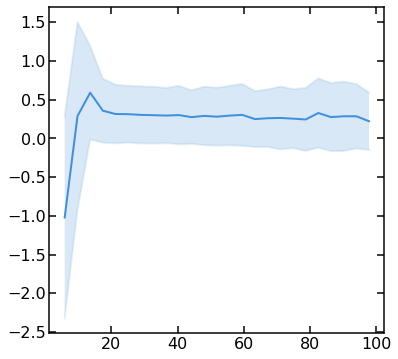

In [141]:
# Draw plot with error bars and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(6,6))
#ax.errorbar(res_18_profile['gen_pt_18_bin_mid'], res_18_profile['res_18_mean'],res_18_profile['res_18_std'] , color='tab:blue', ecolor='tab:blue')
ax.plot(res_18_profile['gen_pt_18_bin_mid'], res_18_profile['res_18_mean'], label='signal mean')
ax.plot(res_18_profile['gen_pt_18_bin_mid'], res_18_profile['res_18_mean']-res_18_profile['res_18_std'] , color='tab:blue', alpha=0.1)
ax.plot(res_18_profile['gen_pt_18_bin_mid'], res_18_profile['res_18_mean']+res_18_profile['res_18_std'] , color='tab:blue', alpha=0.1)
ax.fill_between(res_18_profile['gen_pt_18_bin_mid'], res_18_profile['res_18_mean']-res_18_profile['res_18_std'], res_18_profile['res_18_mean']+res_18_profile['res_18_std'], alpha=0.2)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
plt.show()

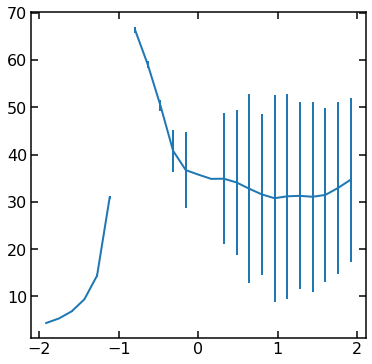

In [137]:
# Draw plot with error bars and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(6,6))
ax.errorbar(gen_pt_profile['res_18_bin_mid'], gen_pt_profile['gen_pt_mean'],gen_pt_profile['gen_pt_std'] , color='tab:blue', ecolor='tab:blue')
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
plt.show()

In [14]:
def plot_fill(x,y,lower,upper,ax):
    ax.plot(x,y, color='tab:blue')
    ax.plot(x,lower, color='tab:blue', alpha=0.1)
    ax.plot(x,upper , color='tab:blue', alpha=0.1)
    ax.fill_between(x,lower,upper, color='tab:blue', alpha=0.2)
    return ax

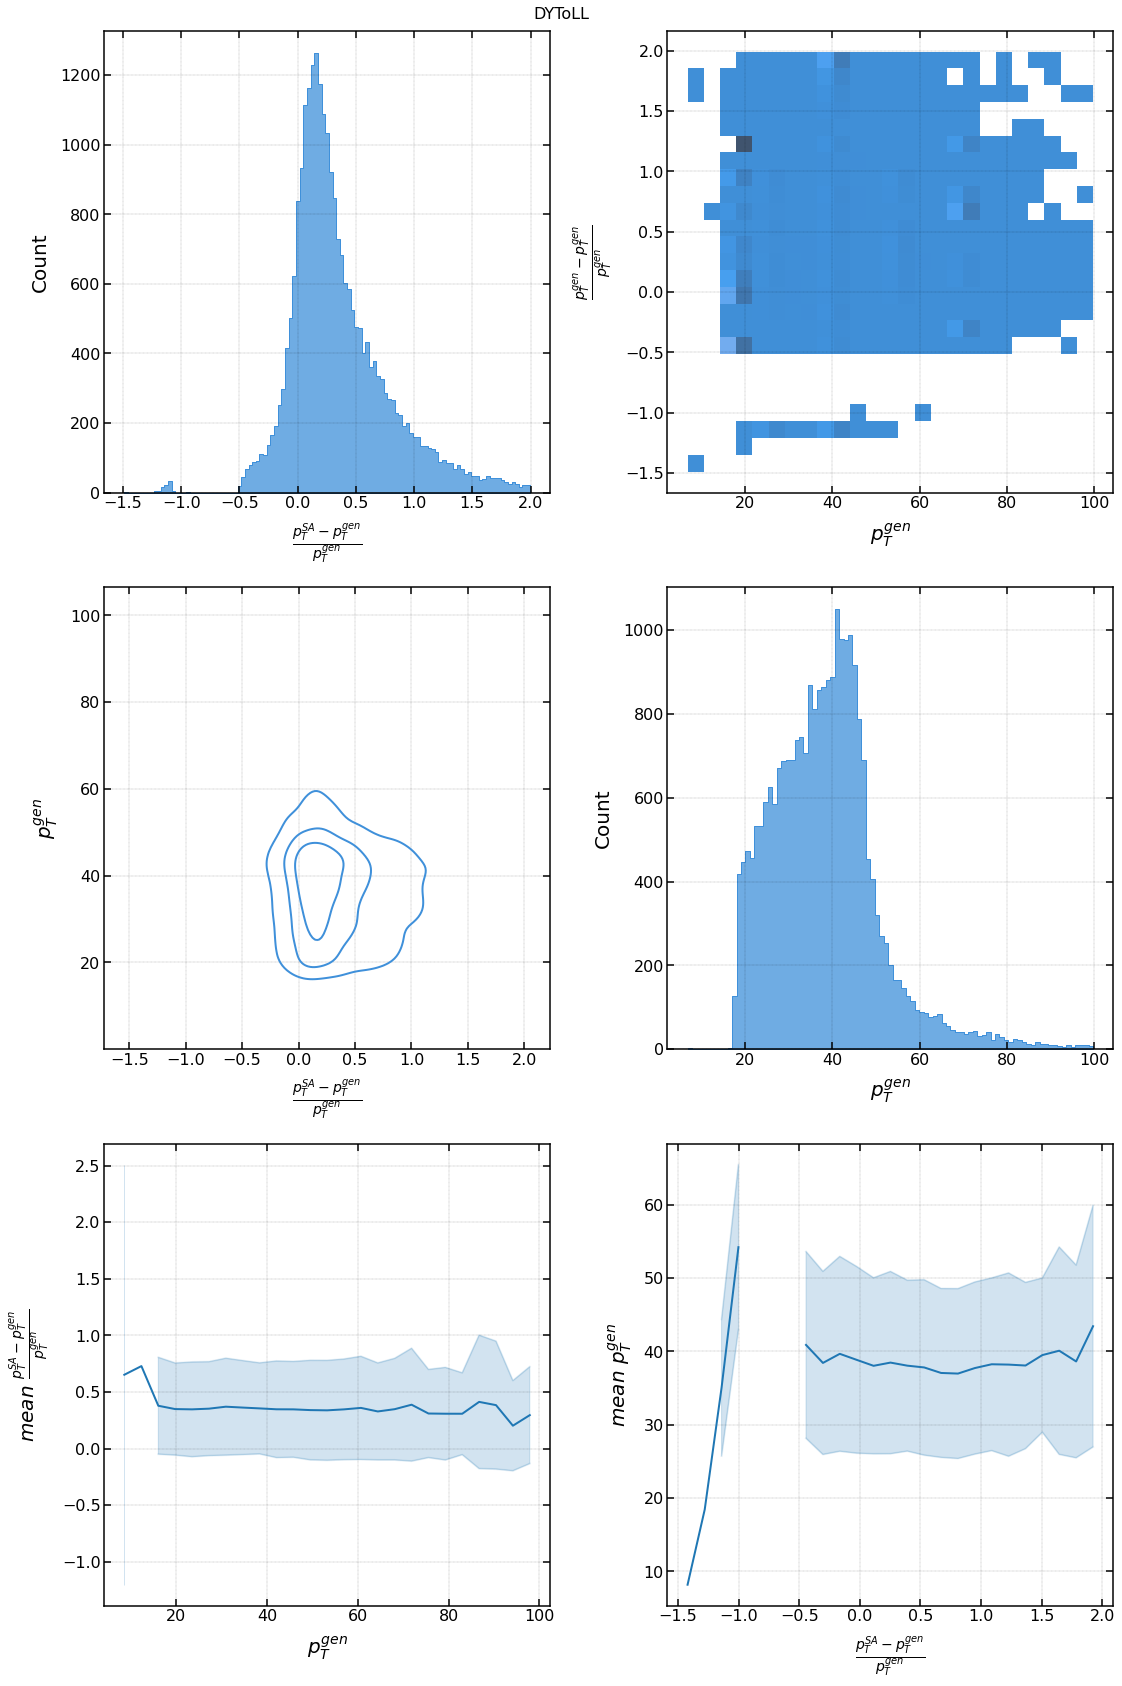

In [177]:
fig, ax = plt.subplots(3,2,figsize=(16,24), gridspec_kw=dict(width_ratios=[4,4]))
p1 = sns.histplot(data=df, x='res_18', kde=False,fill=True, element="step", ax=ax[0,0])
p1.set(xlabel=r'$\frac{p^{SA}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$')
p2 = sns.histplot(data=df, x='gen_pt_18',y='res_18',bins=(bins_pt,bins_res),stat='count',weights='inv_2dbin_count', ax=ax[0,1])#binwidth=(5,0.05)
p2.set(xlabel=r'$p^{gen}_{T}$',ylabel=r'$\frac{p^{gen}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$')
p3 = sns.kdeplot(data=df, x='res_18',y='gen_pt_18', fill=False, thresh=.2, levels=4,ax=ax[1,0])
p3.set(xlabel=r'$\frac{p^{SA}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$',ylabel=r'$p^{gen}_{T}$')
p4 = sns.histplot(data=df, x='gen_pt_18', kde=False,fill=True, element="step", ax=ax[1,1])
p4.set(xlabel=r'$p^{gen}_{T}$')
p5 = plot_fill(gen_pt_profile['res_18_bin_mid'], gen_pt_profile['gen_pt_mean'],gen_pt_profile['gen_pt_mean']-gen_pt_profile['gen_pt_std'],gen_pt_profile['gen_pt_mean']+gen_pt_profile['gen_pt_std'],ax[2,1])
p5.set(xlabel=r'$\frac{p^{SA}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$',ylabel=r'$mean~p^{gen}_{T}$')
p6 = plot_fill(res_18_profile['gen_pt_18_bin_mid'], res_18_profile['res_18_mean'],res_18_profile['res_18_mean']-res_18_profile['res_18_std'],res_18_profile['res_18_mean']+res_18_profile['res_18_std'],ax[2,0])
p6.set(xlabel=r'$p^{gen}_{T}$',ylabel=r'$mean~\frac{p^{SA}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$')
fig.suptitle('DYToLL', fontsize=16)
for a in ax.flat:
    a.grid(b=True, which='both', color='black', linewidth=0.3,linestyle=':')
fig.tight_layout()

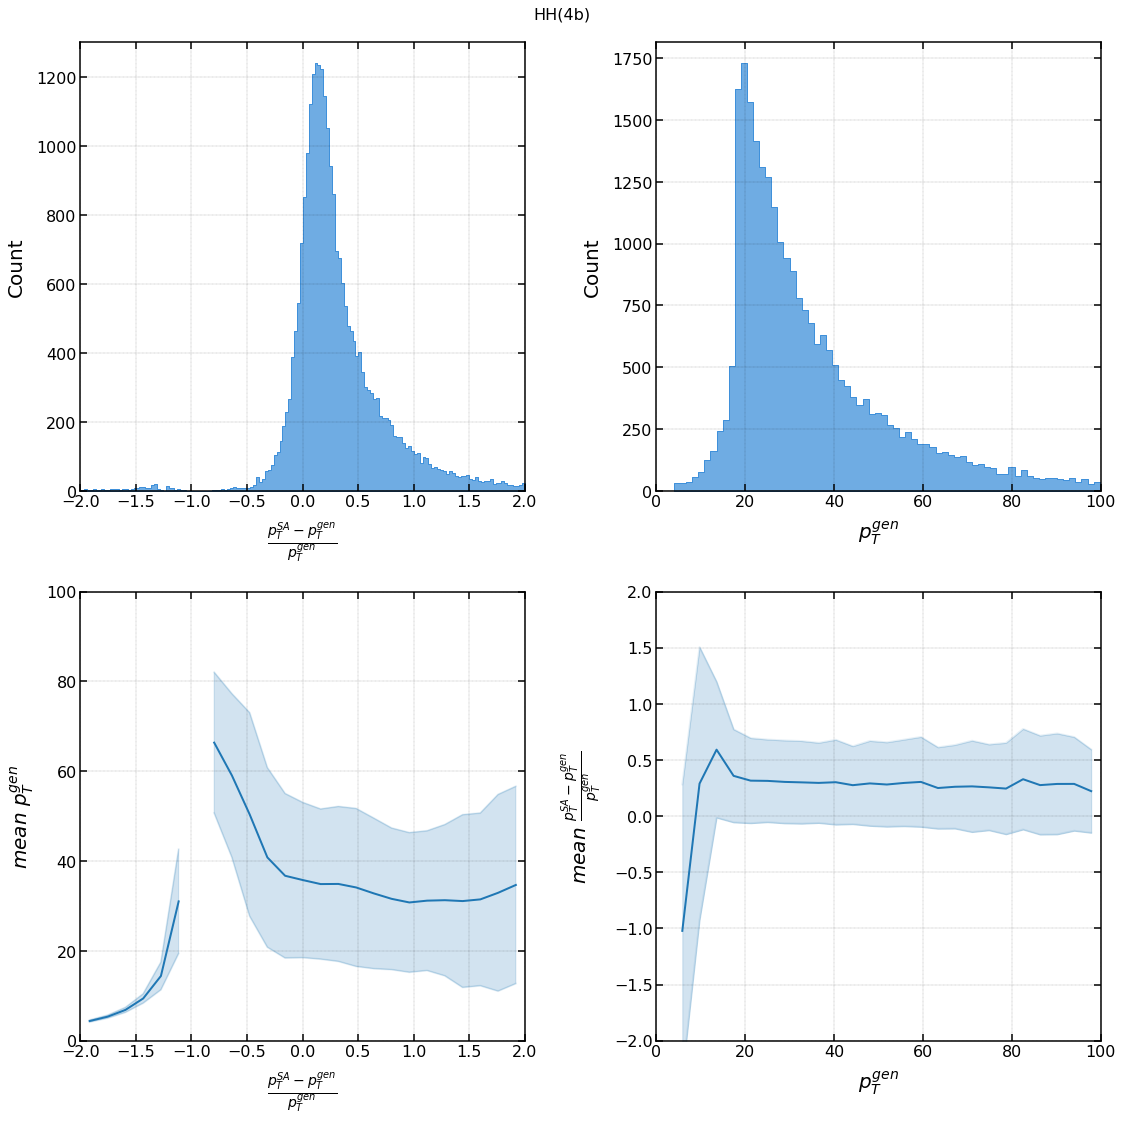

In [28]:
fig, ax = plt.subplots(2,2,figsize=(16,16), gridspec_kw=dict(width_ratios=[4,4]))
p1 = sns.histplot(data=df, x='res_18', kde=False,fill=True, element="step", ax=ax[0,0])
p1.set(xlabel=r'$\frac{p^{SA}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$')
p4 = sns.histplot(data=df, x='gen_pt_18', kde=False,fill=True, element="step", ax=ax[0,1])
p4.set(xlabel=r'$p^{gen}_{T}$')
p5 = plot_fill(gen_pt_profile['res_18_bin_mid'], gen_pt_profile['gen_pt_mean'],gen_pt_profile['gen_pt_mean']-gen_pt_profile['gen_pt_std'],gen_pt_profile['gen_pt_mean']+gen_pt_profile['gen_pt_std'],ax[1,0])
p5.set(xlabel=r'$\frac{p^{SA}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$',ylabel=r'$mean~p^{gen}_{T}$')
p6 = plot_fill(res_18_profile['gen_pt_18_bin_mid'], res_18_profile['res_18_mean'],res_18_profile['res_18_mean']-res_18_profile['res_18_std'],res_18_profile['res_18_mean']+res_18_profile['res_18_std'],ax[1,1])
p6.set(xlabel=r'$p^{gen}_{T}$',ylabel=r'$mean~\frac{p^{SA}_{T}-p^{gen}_{T}}{p^{gen}_{T}}$')
fig.suptitle('HH(4b)', fontsize=16)
ax[0,0].set_xlim([-2, 2])
ax[1,0].set_xlim([-2, 2])
ax[1,1].set_ylim([-2, 2])
ax[0,1].set_xlim([0, 100])
ax[1,1].set_xlim([0, 100])
ax[1,0].set_ylim([0, 100])
for a in ax.flat:
    a.grid(b=True, which='both', color='black', linewidth=0.3,linestyle=':')
fig.tight_layout()
plt.savefig('HH4b_plot.pdf')

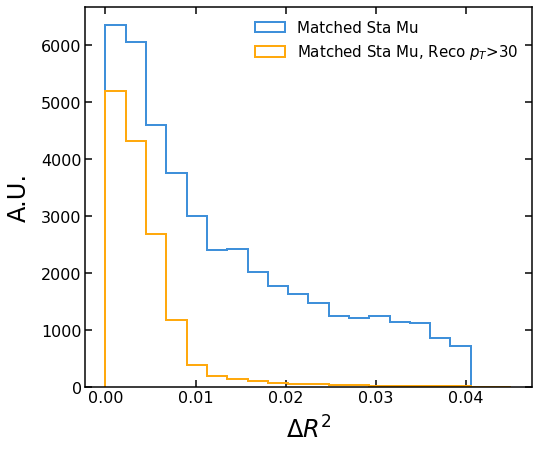

In [20]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')


mask_mat = np.where(all_reco_matched_pf_muons[:].pt>=0,True,False)
mask_mat_30 = np.where(all_reco_matched_pf_muons[:].pt>30,True,False)*np.where(gen_pf_muons[:].pt>0.,True,False)*(np.where(abs(gen_pf_muons[:].eta)>=0.,True,False))

xmax = 0.045
xmin =  0.0
n_bins = 20
plot_range = (xmin,xmax)
res = deltaR2_array(gen_pf_muons.eta[mask_mat],gen_pf_muons.phi[mask_mat],all_reco_matched_sta_muons.eta[mask_mat],all_reco_matched_sta_muons.phi[mask_mat])
res_30 = deltaR2_array(gen_pf_muons.eta[mask_mat_30],gen_pf_muons.phi[mask_mat_30],all_reco_matched_sta_muons.eta[mask_mat_30],all_reco_matched_sta_muons.phi[mask_mat_30])

_,bins,_ = plt.hist(res, bins=n_bins,range = plot_range,density=False, histtype='step', fill=False, linewidth=2,label='Matched Sta Mu')
_,_,_ = plt.hist(res_30, bins=bins,density=False, histtype='step', fill=False, linewidth=2,label=r'Matched Sta Mu, Reco $p_T$>30')#, Gen |eta|>2.')
#plt.vlines(0.75, 0, 800,color='black',linestyle='--') 
plt.ylabel("A.U.")
plt.xlabel(r"$\Delta R^2$")
#plt.yscale('log')
plt.legend(fontsize=15)
plt.show()

In [34]:
non_matched_pf_only[0:3]
#np.where(np.array(non_matched_pf_only)<100)

[90112, 81923, 16395]

In [61]:
less_pf_cands = []
gen_more_3_bar = []

pt_above_pt = [] 
eta_above = []
for i_i,i in enumerate(non_matched_pf_only):
    e = events_record[i]
    if len(e.pf_muons.pt)<len(e.gen_muons.pt):
        less_pf_cands.append(i)
    if np.all(e.sta_muons.pt>30):
        pt_above_pt.append(i)
    if np.all(abs(e.gen_muons.eta)>2) and np.all(abs(e.gen_muons.eta)<2.5):
        eta_above.append(i)

In [79]:
less_pf_cands

[24582,
 34826,
 51213,
 90135,
 6180,
 22567,
 112682,
 118829,
 110649,
 96317,
 129086,
 69695,
 75839,
 79953,
 57426,
 84055,
 96347,
 131178,
 92262,
 118896,
 16507,
 131197,
 43141,
 32903,
 61576,
 53386,
 51350,
 30872,
 84124,
 133283,
 51380,
 6326,
 47295,
 196,
 39119,
 39121,
 96474,
 63710,
 131298,
 59625,
 41194,
 33003,
 119022,
 51441,
 94457,
 24826,
 24831,
 6402,
 20739,
 20741,
 49421,
 65807,
 129298,
 71955,
 47390,
 78113,
 96555,
 106806,
 78139,
 16707,
 100676,
 67910,
 59735,
 76137,
 29045,
 27000,
 80250,
 123259,
 123263,
 63878,
 31113,
 37259,
 127381,
 33175,
 41369,
 117147,
 92575,
 133545,
 100782,
 6579,
 84419,
 59846,
 108999,
 29142,
 49623,
 66011,
 127460,
 135661,
 86513,
 49655,
 23032,
 111103,
 51717,
 27142,
 8715,
 104973,
 14867,
 535,
 33309,
 23073,
 109090,
 96808,
 86569,
 78378,
 27180,
 88635,
 35390,
 72257,
 14916,
 90693,
 49734,
 113234,
 21075,
 35431,
 84583,
 45677,
 113279,
 101000,
 47777,
 49827,
 90806,
 88760,
 2117

In [114]:
i = non_matched_pf_only[6]
e = events_record[i]
print("Record : {},".format(i),e.event)
print("Gen Mu pT, eta, phi : ",e.gen_muons.pt,e.gen_muons.eta,e.gen_muons.phi,e.gen_muons.prompt)
print("Sta  Mu pT, eta, phi : ",e.sta_muons.pt,e.sta_muons.eta,e.sta_muons.phi,e.sta_muons.quality)
print("PF Mu pT, eta, phi : ",e.pf_muons.pt,e.pf_muons.eta,e.pf_muons.phi,e.pf_muons.quality)

Record : 131095, {event: 63604}
Gen Mu pT, eta, phi :  [15.9] [1.12] [2.2] [0]
Sta  Mu pT, eta, phi :  [6, 6] [-1.77, 1.12] [-1.98, 2.34] [12, 12]
PF Mu pT, eta, phi :  [7, 5.5] [0.955, -1.75] [2.39, -2.27] [12, 12]


In [108]:
non_matched_pf_only

[75781,
 24582,
 43014,
 120837,
 34826,
 51213,
 131095,
 10264,
 90135,
 53275,
 32802,
 6180,
 49190,
 22567,
 133162,
 112682,
 114730,
 47149,
 118829,
 32822,
 110649,
 96317,
 129086,
 69695,
 75839,
 75844,
 41029,
 104517,
 2127,
 79953,
 57426,
 84055,
 69720,
 96347,
 2150,
 59494,
 77927,
 75881,
 131178,
 92262,
 112744,
 120939,
 118896,
 102518,
 28792,
 57466,
 16507,
 90235,
 131197,
 43141,
 6279,
 32903,
 61576,
 53386,
 135309,
 90254,
 51344,
 116885,
 41110,
 51350,
 30872,
 84124,
 59549,
 39070,
 133283,
 14499,
 8358,
 30887,
 12459,
 10414,
 49327,
 37040,
 118963,
 51380,
 6326,
 2232,
 125112,
 16573,
 2238,
 47295,
 75967,
 53441,
 114883,
 196,
 86217,
 30924,
 32974,
 39119,
 39121,
 96472,
 96474,
 63710,
 131298,
 24807,
 59625,
 41194,
 33003,
 84205,
 119022,
 110831,
 49392,
 51441,
 78065,
 94457,
 24826,
 63738,
 24831,
 6402,
 20739,
 20741,
 65803,
 49421,
 65807,
 129298,
 71955,
 22805,
 96533,
 119065,
 119068,
 104733,
 35102,
 47390,
 78113,

In [64]:
print(len(less_pf_cands),len(non_matched_pf_only))

332 739


In [95]:
np.where(np.array(less_pf_cands)<1000)

(array([ 33,  97, 124, 129]),)

In [78]:
np.where(np.array(non_matched_sta_events)==129086)

(array([], dtype=int64),)

In [53]:
sta_above_pt = [] 
for i_i,i in enumerate(non_matched_sta_events):
    e = events_record[i]
    if np.all(e.sta_muons.pt>30):
        sta_above_pt.append(i)

In [72]:
less_pf_cands

[24582,
 34826,
 51213,
 90135,
 6180,
 22567,
 112682,
 118829,
 110649,
 96317,
 129086,
 69695,
 75839,
 79953,
 57426,
 84055,
 96347,
 131178,
 92262,
 118896,
 16507,
 131197,
 43141,
 32903,
 61576,
 53386,
 51350,
 30872,
 84124,
 133283,
 51380,
 6326,
 47295,
 196,
 39119,
 39121,
 96474,
 63710,
 131298,
 59625,
 41194,
 33003,
 119022,
 51441,
 94457,
 24826,
 24831,
 6402,
 20739,
 20741,
 49421,
 65807,
 129298,
 71955,
 47390,
 78113,
 96555,
 106806,
 78139,
 16707,
 100676,
 67910,
 59735,
 76137,
 29045,
 27000,
 80250,
 123259,
 123263,
 63878,
 31113,
 37259,
 127381,
 33175,
 41369,
 117147,
 92575,
 133545,
 100782,
 6579,
 84419,
 59846,
 108999,
 29142,
 49623,
 66011,
 127460,
 135661,
 86513,
 49655,
 23032,
 111103,
 51717,
 27142,
 8715,
 104973,
 14867,
 535,
 33309,
 23073,
 109090,
 96808,
 86569,
 78378,
 27180,
 88635,
 35390,
 72257,
 14916,
 90693,
 49734,
 113234,
 21075,
 35431,
 84583,
 45677,
 113279,
 101000,
 47777,
 49827,
 90806,
 88760,
 2117

In [55]:
pf_above_pt = [] 
for i_i,i in enumerate(non_matched_pf_events):
    e = events_record[i]
    if np.all(e.sta_muons.pt>30):
        pf_above_pt.append(i)

In [56]:
len(pf_above_pt)

262

In [57]:
len(set(pf_above_pt))

254

In [59]:
pf_above_pt_only = [] 
for i_i,i in enumerate(non_matched_pf_only):
    e = events_record[i]
    if np.all(e.sta_muons.pt>30):
        pf_above_pt_only.append(i)

In [60]:
len(pf_above_pt_only)

192

In [11]:
print('f')

f


In [16]:
df = pd.DataFrame(dict(A=np.random.rand(20), B=np.random.rand(20)))


In [17]:
d1 = df.assign(
    A_cut=pd.qcut(df.A, 2, labels=[1, 2]),
    B_cut=pd.qcut(df.B, 2, labels=list('ab'))
)

In [18]:
d2 = d1.assign(cartesian=pd.Categorical(d1.filter(regex='_cut').apply(tuple, 1)))
print(d2)


           A         B A_cut B_cut cartesian
0   0.459992  0.005803     2     a    (2, a)
1   0.124606  0.821592     1     b    (1, b)
2   0.174470  0.697508     1     b    (1, b)
3   0.518843  0.564004     2     a    (2, a)
4   0.128076  0.586791     1     a    (1, a)
5   0.348977  0.823839     1     b    (1, b)
6   0.699522  0.734852     2     b    (2, b)
7   0.438866  0.517803     1     a    (1, a)
8   0.627208  0.630414     2     b    (2, b)
9   0.992455  0.281507     2     a    (2, a)
10  0.076440  0.862111     1     b    (1, b)
11  0.448289  0.875144     2     b    (2, b)
12  0.823546  0.205582     2     a    (2, a)
13  0.765851  0.028961     2     a    (2, a)
14  0.953124  0.792214     2     b    (2, b)
15  0.265016  0.788123     1     b    (1, b)
16  0.541480  0.122217     2     a    (2, a)
17  0.445610  0.248689     1     a    (1, a)
18  0.099475  0.992913     1     b    (1, b)
19  0.009085  0.292052     1     a    (1, a)


In [19]:
pd.cut(df['A'], 10)

0      (0.402, 0.501]
1      (0.107, 0.206]
2      (0.107, 0.206]
3      (0.501, 0.599]
4      (0.107, 0.206]
5      (0.304, 0.402]
6      (0.697, 0.796]
7      (0.402, 0.501]
8      (0.599, 0.697]
9      (0.894, 0.992]
10    (0.0081, 0.107]
11     (0.402, 0.501]
12     (0.796, 0.894]
13     (0.697, 0.796]
14     (0.894, 0.992]
15     (0.206, 0.304]
16     (0.501, 0.599]
17     (0.402, 0.501]
18    (0.0081, 0.107]
19    (0.0081, 0.107]
Name: A, dtype: category
Categories (10, interval[float64]): [(0.0081, 0.107] < (0.107, 0.206] < (0.206, 0.304] < (0.304, 0.402] ... (0.599, 0.697] < (0.697, 0.796] < (0.796, 0.894] < (0.894, 0.992]]

In [24]:
df = pd.DataFrame(dict(A=np.random.rand(20), B=np.random.rand(20)))
df['A_binned'] = pd.cut(df['A'], 3)
df['B_binned'] = pd.cut(df['B'], 3)


,A,B,A_binned,B_binned,cartesian
0,0.459992,0.005803,"(0.402, 0.501]","(0.00482, 0.105]","((0.402, 0.501], (0.00482, 0.105])"
1,0.124606,0.821592,"(0.107, 0.206]","(0.795, 0.894]","((0.107, 0.206], (0.795, 0.894])"
2,0.174470,0.697508,"(0.107, 0.206]","(0.697, 0.795]","((0.107, 0.206], (0.697, 0.795])"
3,0.518843,0.564004,"(0.501, 0.599]","(0.499, 0.598]","((0.501, 0.599], (0.499, 0.598])"
4,0.128076,0.586791,"(0.107, 0.206]","(0.499, 0.598]","((0.107, 0.206], (0.499, 0.598])"
5,0.348977,0.823839,"(0.304, 0.402]","(0.795, 0.894]","((0.304, 0.402], (0.795, 0.894])"
6,0.699522,0.734852,"(0.697, 0.796]","(0.697, 0.795]","((0.697, 0.796], (0.697, 0.795])"
7,0.438866,0.517803,"(0.402, 0.501]","(0.499, 0.598]","((0.402, 0.501], (0.499, 0.598])"
8,0.627208,0.630414,"(0.599, 0.697]","(0.598, 0.697]","((0.599, 0.697], (0.598, 0.697])"
9,0.992455,0.281507,"(0.894, 0.992]","(0.203, 0.302]","((0.894, 0.992], (0.203, 0.302])"


In [33]:
df = pd.DataFrame(dict(A=np.random.rand(20), B=np.random.rand(20)))
df['A_binned'] = pd.cut(df['A'], 3)
df['B_binned'] = pd.cut(df['B'], 3)
d2 = df.assign(cartesian=pd.Categorical(df.filter(regex='_binned').apply(tuple, 1)))
d2['count']= d2.cartesian.map(d2.cartesian.value_counts())
print(d2)

           A         B         A_binned         B_binned  \
0   0.999929  0.362789     (0.677, 1.0]   (0.349, 0.672]   
1   0.654301  0.979328   (0.354, 0.677]   (0.672, 0.995]   
2   0.487948  0.076122   (0.354, 0.677]  (0.0246, 0.349]   
3   0.652994  0.995255   (0.354, 0.677]   (0.672, 0.995]   
4   0.140173  0.952033  (0.0294, 0.354]   (0.672, 0.995]   
5   0.601290  0.037168   (0.354, 0.677]  (0.0246, 0.349]   
6   0.304992  0.644595  (0.0294, 0.354]   (0.349, 0.672]   
7   0.196083  0.400619  (0.0294, 0.354]   (0.349, 0.672]   
8   0.044773  0.991465  (0.0294, 0.354]   (0.672, 0.995]   
9   0.370961  0.396813   (0.354, 0.677]   (0.349, 0.672]   
10  0.104487  0.109639  (0.0294, 0.354]  (0.0246, 0.349]   
11  0.725297  0.881477     (0.677, 1.0]   (0.672, 0.995]   
12  0.030326  0.560385  (0.0294, 0.354]   (0.349, 0.672]   
13  0.775879  0.214940     (0.677, 1.0]  (0.0246, 0.349]   
14  0.762879  0.182151     (0.677, 1.0]  (0.0246, 0.349]   
15  0.977334  0.695168     (0.677, 1.0] 

In [34]:
pd.value_counts(d2['cartesian'])


((0.0294, 0.354], (0.349, 0.672])     3
((0.0294, 0.354], (0.672, 0.995])     3
((0.677, 1.0], (0.0246, 0.349])       3
((0.677, 1.0], (0.349, 0.672])        3
((0.354, 0.677], (0.0246, 0.349])     2
((0.354, 0.677], (0.672, 0.995])      2
((0.677, 1.0], (0.672, 0.995])        2
((0.0294, 0.354], (0.0246, 0.349])    1
((0.354, 0.677], (0.349, 0.672])      1
Name: cartesian, dtype: int64

In [36]:
d2

,A,B,A_binned,B_binned,cartesian,count
0,0.999929,0.362789,"(0.677, 1.0]","(0.349, 0.672]","((0.677, 1.0], (0.349, 0.672])",3
1,0.654301,0.979328,"(0.354, 0.677]","(0.672, 0.995]","((0.354, 0.677], (0.672, 0.995])",2
2,0.487948,0.076122,"(0.354, 0.677]","(0.0246, 0.349]","((0.354, 0.677], (0.0246, 0.349])",2
3,0.652994,0.995255,"(0.354, 0.677]","(0.672, 0.995]","((0.354, 0.677], (0.672, 0.995])",2
4,0.140173,0.952033,"(0.0294, 0.354]","(0.672, 0.995]","((0.0294, 0.354], (0.672, 0.995])",3
5,0.601290,0.037168,"(0.354, 0.677]","(0.0246, 0.349]","((0.354, 0.677], (0.0246, 0.349])",2
6,0.304992,0.644595,"(0.0294, 0.354]","(0.349, 0.672]","((0.0294, 0.354], (0.349, 0.672])",3
7,0.196083,0.400619,"(0.0294, 0.354]","(0.349, 0.672]","((0.0294, 0.354], (0.349, 0.672])",3
8,0.044773,0.991465,"(0.0294, 0.354]","(0.672, 0.995]","((0.0294, 0.354], (0.672, 0.995])",3
9,0.370961,0.396813,"(0.354, 0.677]","(0.349, 0.672]","((0.354, 0.677], (0.349, 0.672])",1


In [49]:
len(df)

25244

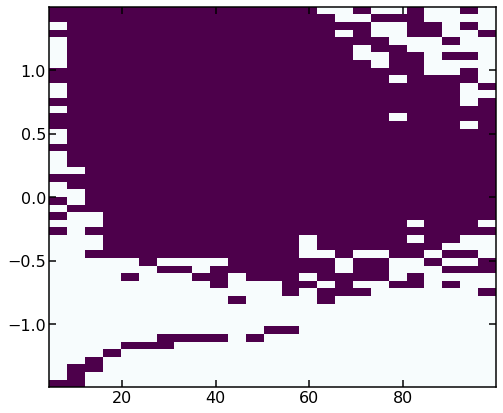

In [63]:
plt.hist2d(df['gen_pt_18'], df['res_18'], bins=(bins_pt,bins_res), cmap=plt.cm.BuPu,weights=df['inv_2dbin_density'])
plt.show()

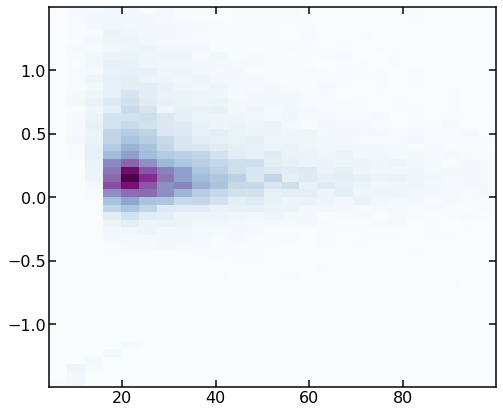

In [61]:
plt.hist2d(df['gen_pt_18'], df['res_18'], bins=(bins_pt,bins_res), cmap=plt.cm.BuPu)
plt.show()

In [ ]:
p2 = sns.histplot(data=df, x='gen_pt_18',y='res_18',bins=(bins_pt,bins_res),stat='density',weights='inv_2dbin_density', ax=ax[0,1],cbar=True)#binwidth=(5,0.05)
